In [1]:
import os
os.chdir('/pscratch/sd/j/jzweifel/e3sm_scratch/pm-cpu')

In [2]:
import xarray as xr

# Step 1: Load datasets
file_paths = [
    'Hyun_Nudging_Test/run/blended_1850_h1.nc',
    'Hyun_Nudging_Test/run/blended_1850_h2.nc',
    'Hyun_Nudging_Test/run/blended_1850_h3.nc',
    'Hyun_Nudging_Test/run/blended_1850_h4.nc',
    'Hyun_Nudging_Test/run/blended_1850_h5.nc',
]

datasets = [xr.open_dataset(fp) for fp in file_paths]

# Step 2: Extract only 4D variables from each
filtered_datasets = []
for ds in datasets:
    four_d_vars = [var for var in ds.data_vars if ds[var].ndim == 4]
    filtered_datasets.append(ds[four_d_vars])

# Step 3: Combine all 4D-variable datasets
combined_4d = xr.merge(filtered_datasets)

In [3]:
combined_4d

<xarray.Dataset> Size: 3GB
Dimensions:           (time: 1, lev: 80, lat: 180, lon: 360, ilev: 81)
Coordinates:
  * lat               (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon               (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * ilev              (ilev) float64 648B 0.1 0.1472 0.2166 ... 997.0 1e+03
  * lev               (lev) float64 640B 0.1236 0.1819 0.2674 ... 993.8 998.5
  * time              (time) object 8B 2000-01-31 00:00:00
Data variables: (12/162)
    CT_H2O2           (time, lev, lat, lon) float32 21MB ...
    CT_H2SO4          (time, lev, lat, lon) float32 21MB ...
    CT_SO2            (time, lev, lat, lon) float32 21MB ...
    CT_so4_a1         (time, lev, lat, lon) float32 21MB ...
    CT_so4_a2         (time, lev, lat, lon) float32 21MB ...
    CT_so4_a3         (time, lev, lat, lon) float32 21MB ...
    ...                ...
    so4_a2_CHML       (time, lev, lat, lon) float32 21MB ...
    so4_a2_CHMP       (time, lev, lat, lon) float32 21MB ...
    so4_a3_CHML       (time, lev, lat, lon) float32 21MB ...
    so4_a3_CHMP       (time, lev, lat, lon) float32 21MB ...
    usr_DMS_OH        (time, lev, lat, lon) float32 21MB ...
    usr_SO2_OH        (time, lev, lat, lon) float32 21MB ...
Attributes: (12/26)
    ne:                        30
    fv_nphys:                  2
    title:                     EAM History file information
    source:                    E3SM Atmosphere Model
    source_id:                 72d95bb31e
    product:                   model-output
    ...                        ...
    remap_hostname:            nid004166
    remap_version:             5.3.3
    NCO:                       netCDF Operators version 5.3.3 (Homepage = htt...
    nco_openmp_thread_number:  2
    map_file:                  map_ne30pg2_to_cmip6_180x360_traave.20231201.nc
    input_file:                /pscratch/sd/j/jzweifel/e3sm_scratch/pm-cpu/Hy...

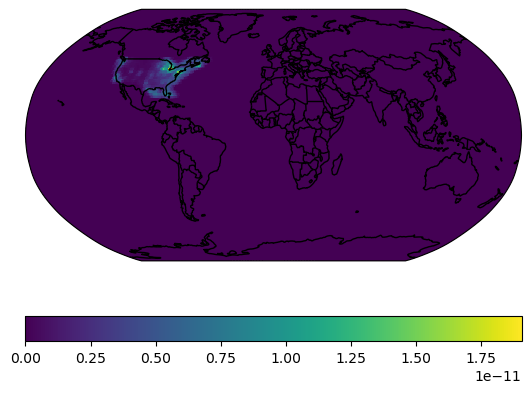

In [4]:
h1_base = xr.open_dataset('one_month_base/run/base_h1.nc')

SO2_SRF_diff = (h1_base['SFSO2'] - datasets[0]['SFSO2'])

from matplotlib import pyplot as plt
from cartopy import crs as ccrs, feature as cfeature

fig, axs = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})

m0 = axs.pcolormesh(SO2_SRF_diff.lon, SO2_SRF_diff.lat, SO2_SRF_diff[0], transform = ccrs.PlateCarree())
axs.add_feature(cfeature.BORDERS)
axs.add_feature(cfeature.COASTLINE)

fig.colorbar(m0, ax=axs, orientation='horizontal')

In [21]:
model_data = xr.open_dataset('/pscratch/sd/j/jzweifel/e3sm_scratch/pm-cpu/hyun_test_2/run/regridding_directory/model_h3_rgr.nc')

MERRA2_day1 = xr.open_dataset('/pscratch/sd/j/jzweifel/e3sm_scratch/pm-cpu/hyun_test_2/run/regridding_directory/MERRA2_rgr_2009_01_01.nc')
MERRA2_day2 = xr.open_dataset('/pscratch/sd/j/jzweifel/e3sm_scratch/pm-cpu/hyun_test_2/run/regridding_directory/MERRA2_rgr_2009_01_02.nc')
MERRA2_day3 = xr.open_dataset('/pscratch/sd/j/jzweifel/e3sm_scratch/pm-cpu/hyun_test_2/run/regridding_directory/MERRA2_rgr_2009_01_03.nc')

MERRA2_data = xr.concat([MERRA2_day1, MERRA2_day2, MERRA2_day3], dim='time')

In [60]:
import numpy as np
from matplotlib.colors import Normalize

# Extract the 6 relevant 2D arrays from model and MERRA2
all_data = np.stack([
    model_data['T'][0][0].values,
    model_data['T'][1][0].values,
    model_data['T'][2][0].values,
    MERRA2_data['T'][0][0].values,
    MERRA2_data['T'][1][0].values,
    MERRA2_data['T'][2][0].values,
])

norm = Normalize(vmin=np.percentile(all_data, 1), vmax=np.percentile(all_data, 99))

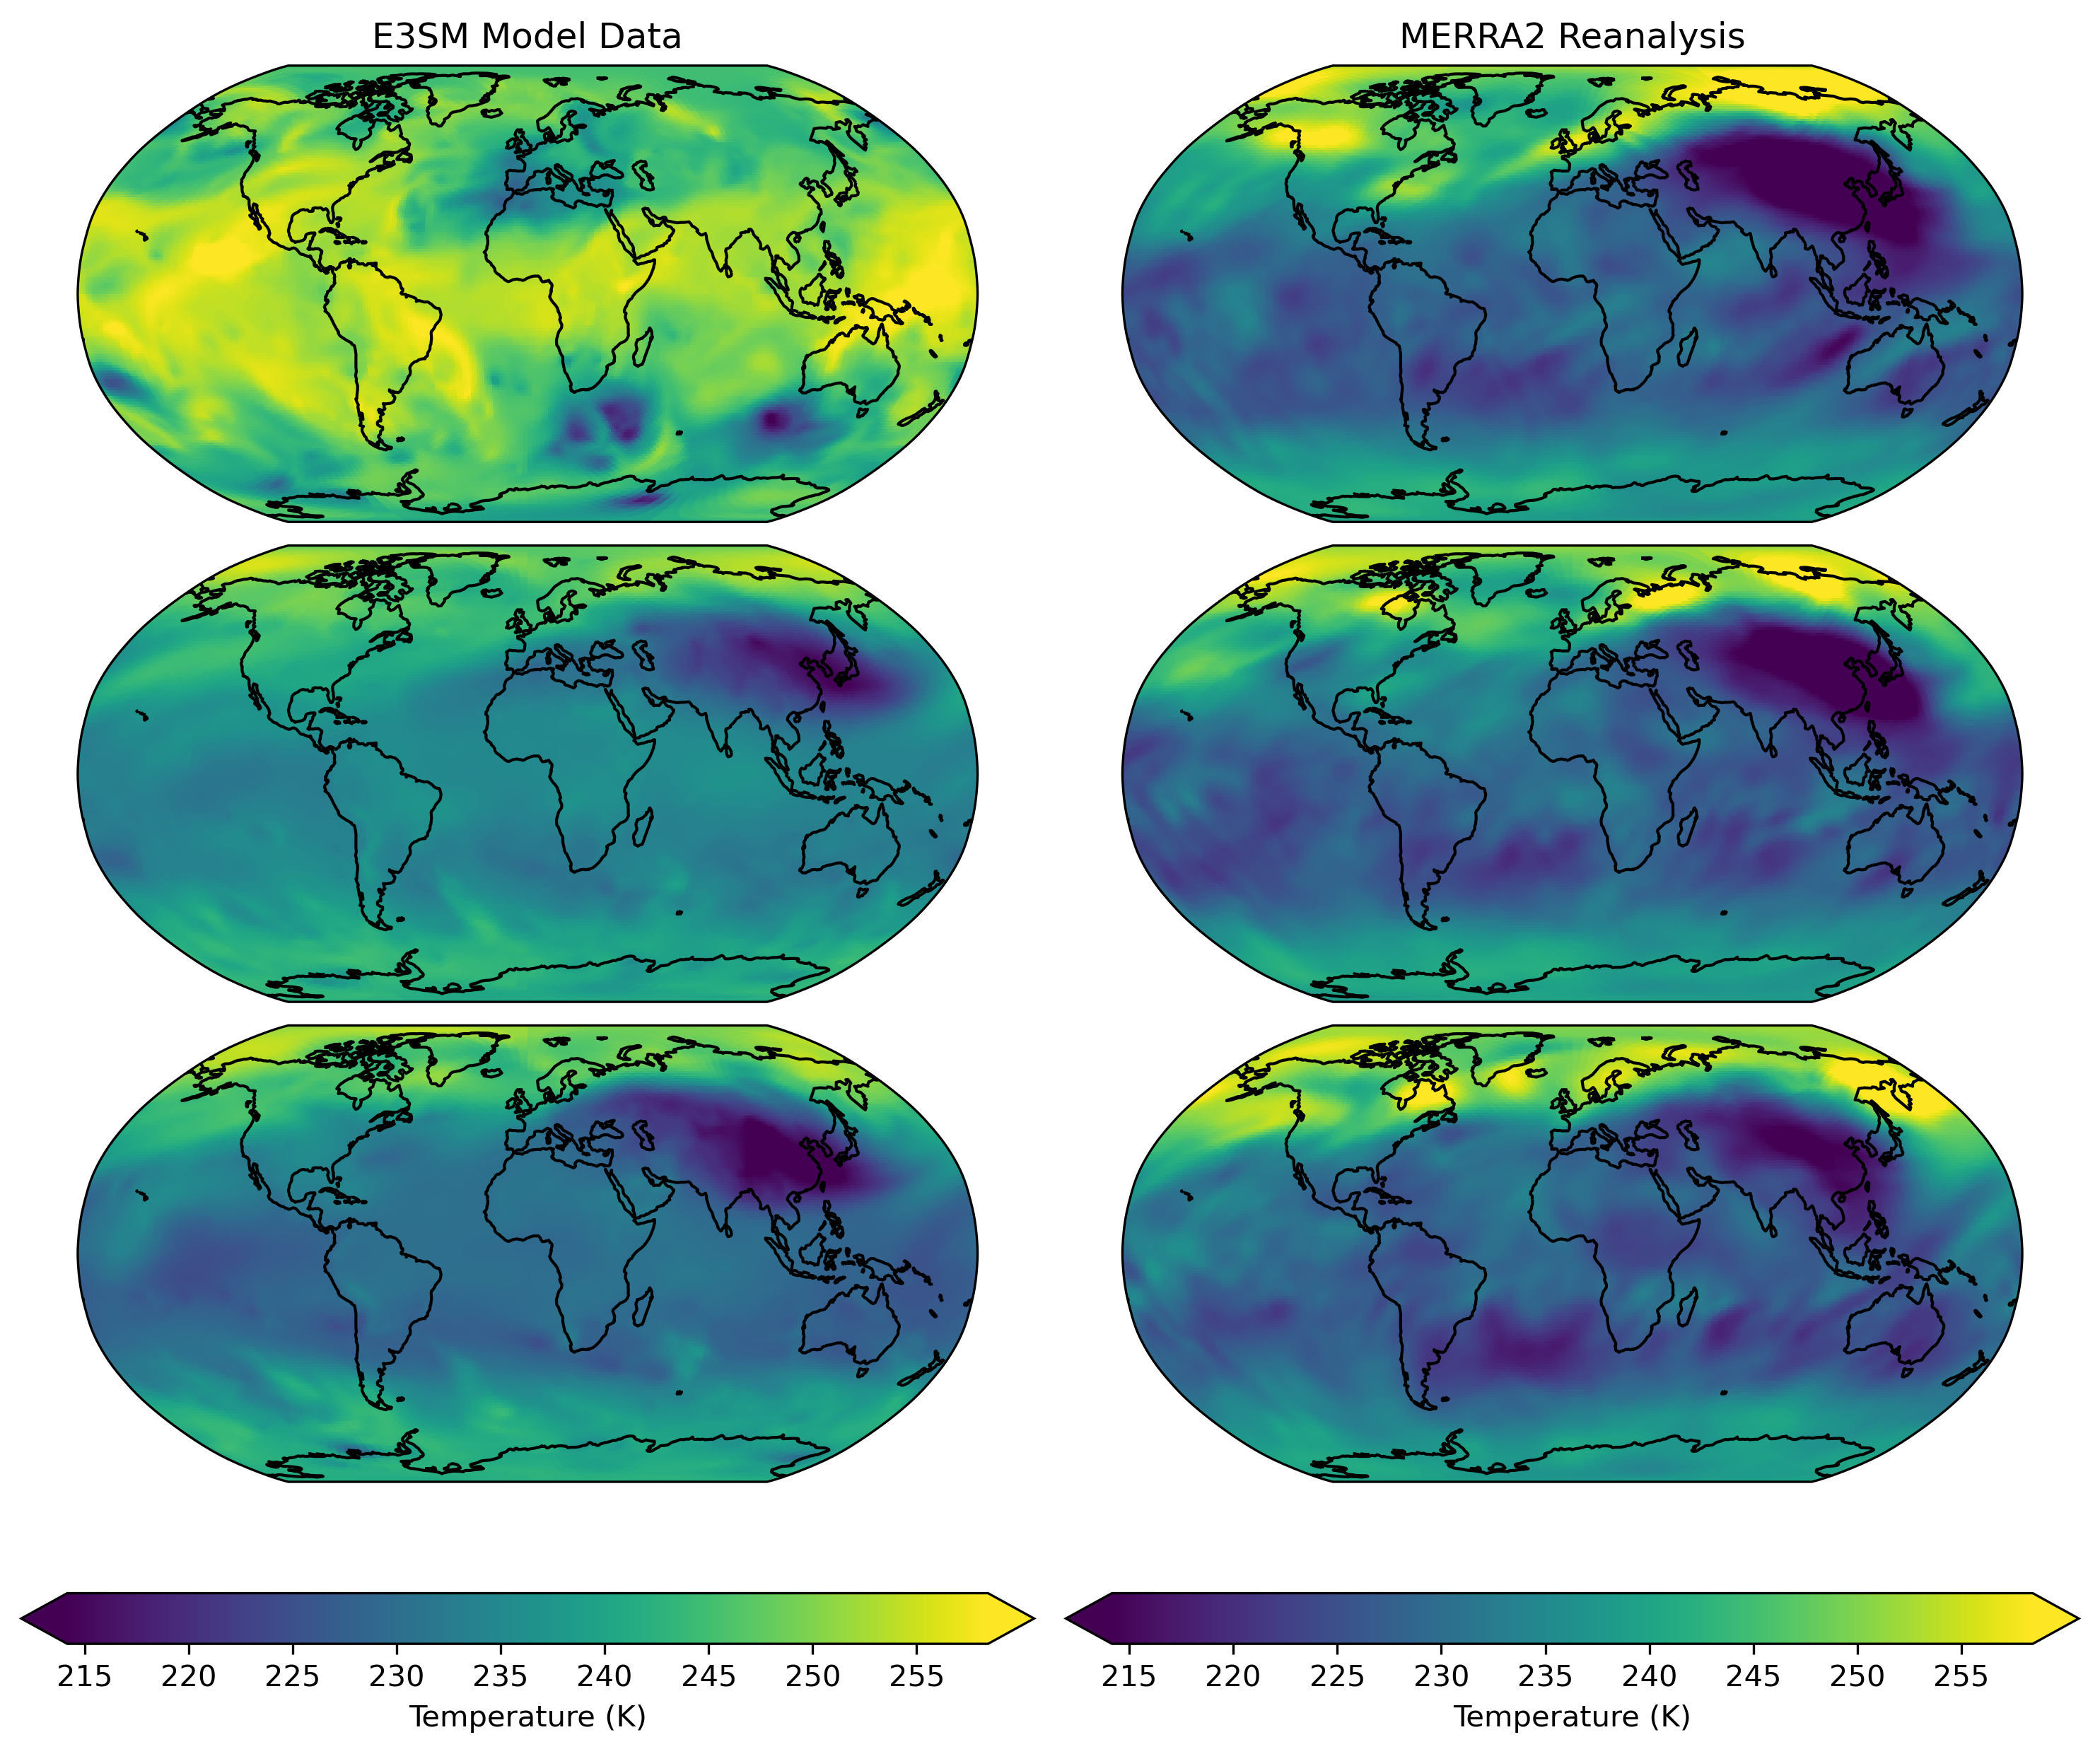

In [69]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature

fig, axs = plt.subplots(3, 2, subplot_kw={'projection': ccrs.Robinson()}, dpi=300, figsize=(10, 8))

# Plot model data
model_plots = [
    axs[0, 0].pcolormesh(model_data.lon, model_data.lat, model_data['T'][0][0], transform=ccrs.PlateCarree(), norm=norm, cmap='viridis'),
    axs[1, 0].pcolormesh(model_data.lon, model_data.lat, model_data['T'][1][0], transform=ccrs.PlateCarree(), norm=norm, cmap='viridis'),
    axs[2, 0].pcolormesh(model_data.lon, model_data.lat, model_data['T'][2][0], transform=ccrs.PlateCarree(), norm=norm, cmap='viridis'),
]

# Plot MERRA2 data
merra_plots = [
    axs[0, 1].pcolormesh(model_data.lon, model_data.lat, MERRA2_data['T'][0][0], transform=ccrs.PlateCarree(), norm=norm, cmap='viridis'),
    axs[1, 1].pcolormesh(model_data.lon, model_data.lat, MERRA2_data['T'][1][0], transform=ccrs.PlateCarree(), norm=norm, cmap='viridis'),
    axs[2, 1].pcolormesh(model_data.lon, model_data.lat, MERRA2_data['T'][2][0], transform=ccrs.PlateCarree(), norm=norm, cmap='viridis'),
]

# Titles
axs[0, 0].set_title('E3SM Model Data')
axs[0, 1].set_title('MERRA2 Reanalysis')

# Add coastlines
for ax in axs.flatten():
    ax.add_feature(cfeature.COASTLINE)

# Adjust layout
plt.tight_layout()  # Leave room for colorbars below

# Colorbar for model column
fig.colorbar(model_plots[0], ax=[axs[0, 0], axs[1, 0], axs[2, 0]],
             orientation='horizontal', fraction=0.04, pad=0.07, label='Temperature (K)', extend='both')

# Colorbar for MERRA2 column
fig.colorbar(merra_plots[0], ax=[axs[0, 1], axs[1, 1], axs[2, 1]],
             orientation='horizontal', fraction=0.04, pad=0.07, label='Temperature (K)', extend='both')